# Cleaning

1. Check for duplicates
2. Normalize hate speech score

# 1. Setup

In [48]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as notebook_tqdm


# Load the dataset from the Hugging Face Hub
notebook_tqdm.tqdm.pandas()
dataset = load_dataset('ucberkeley-dlab/measuring-hate-speech')

# Convert the dataset to a pandas DataFrame
df_raw = dataset['train'].to_pandas()

In [49]:
TRAIN_RATIO = 0.8 # TODO: factor this out everywhere
TEST_RATIO = 0.2
HATE_SPEECH_THRESHOLD_UNNORMALIZED = 0.5
SUPPORTIVE_THRESHOLD_UNNORMALIZED = -1


In [50]:
df_raw.head()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


# 2. Filtering & EDA

Understanding:  
TODO: what do the emotion columns actually mean?  
TODO: what is "status"?  
TODO: what is "outfitms" and "infitms"  
TODO: what is "hypothesis"?
TODO: how, if at all, is the annotator characteristics accounted for in the hate speech score?

EDA:  
TODO: Check out platform distributions  
TODO: Sentiment methodology & distribution  
TODO: Make list of filtering actions for report  
TODO: Make distribtions of emotional dimensions (maybe also scatter grid)  
TODO: distribution of hate_speech_score  
  
Filtering:


### 2.0. Function definitions & variables

In [51]:
def plot_hate_speech_score_histogram(df: pd.DataFrame, hate_threshold: float, supportive_threshold: float):
    """
    Plots a histogram of the hate_speech_score with annotated lines at the thresholds

    Args:
        df (pd.DataFrame): The dataframe to plot the histogram from
        hate_threshold (float): The threshold for hate speech
        supportive_threshold (float): The threshold for supportive speech

    Returns:
        None (plots the histogram)
    """

    total_count = df.shape[0]
    
    # Calculate the amount of values below the supportive threshold
    supportive_count = df[df['hate_speech_score'] < supportive_threshold].shape[0]

    # Calculate the amount of values above the hate threshold
    hate_count = df[df['hate_speech_score'] > hate_threshold].shape[0]

    # Calculate the amount of values between the thresholds
    neutral_count = df[(df['hate_speech_score'] >= supportive_threshold) & (df['hate_speech_score'] <= hate_threshold)].shape[0]

    print(f"Total count: {total_count}")
    print(f"Supportive count: {supportive_count} ({supportive_count / total_count * 100:.2f}%)")
    print(f"Hate count: {hate_count} ({hate_count / total_count * 100:.2f}%)")
    print(f"Neutral count: {neutral_count} ({neutral_count / total_count * 100:.2f}%)")

    # Plot in histogram as well
    plt.hist(df['hate_speech_score'], bins=100)
    plt.axvline(hate_threshold, color='red', linestyle='--', label='Hate Speech Threshold')
    plt.axvline(supportive_threshold, color='blue', linestyle='--', label='Supportive Threshold')
    plt.legend()
    plt.show()

def plot_target_columns_distribution(df: pd.DataFrame, target_cols: list[str]):
    """
    Plots a barchart of the average value of the target columns for the hate speech observations

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distribution)
    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # Calculate the mean value of the target columns for the hate speech observations and sort them descending
    mean_values = hate_speech_df[target_cols].mean()
    mean_values = mean_values.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    mean_values.plot(kind='bar')
    plt.title('Percentage of hate speech columns targeting a specific group')
    plt.xlabel('Target Column')
    plt.ylabel('Percentage of hate speech')
    plt.show()

def plot_target_columns_detailed(df: pd.DataFrame, target_cols: list[str], fig_size: tuple[int, int] = (15, 30), y_max: float = 0.35):
    """
    Plots a bar chart for each of the target columns with detailed breakdowns of sub-groups

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distributions)

    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # initalize axes to plot the 7 sub-groups in two rows of 3 and a last row of 1
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=fig_size)
    # For each of the target columns, make a list of means of of hate speach targeting its sub-groups
    for ax, col in zip(axes.flatten(), target_cols):

        # Calculate the number of observations with a non-zero value for the target column
        non_zero_count = hate_speech_df[col].value_counts()[1]

        # identify all columns in the dataframe that starts with the target column name
        sub_groups_column_names = [column for column in df.columns if column.startswith(col)]

        # remove the original target column from the list
        sub_groups_column_names.remove(col)
        col_name = col.replace("target_", "").title()

        # calculate the mean values for each sub-group
        sub_group_means = hate_speech_df[sub_groups_column_names].mean()
        sub_group_means = sub_group_means.sort_values(ascending=False)

        # remove the col string from the labels
        labels = sub_group_means.index.str.replace((col + "_"), '')

        # plot on the specific axis
        sub_group_means.plot(kind='bar', ax=ax)
        ax.set_xticklabels(labels)
        ax.set_title(f'Percentage of hate speech targeting {col_name} by sub-group \n(n={non_zero_count})')
        ax.set_xlabel('Sub-group')
        ax.set_ylabel('Percentage of hate speech')
        ax.set_ylim(0, y_max)
    
    plt.subplots_adjust(hspace=0.7)

In [52]:
aspect_cols = [
    'insult',
    'humiliate',
    'status',
    'dehumanize',
    'violence',
    'genocide'
]

cols_to_keep = [
    'comment_id', 
    'text', 
    'hate_speech_score',
    *aspect_cols,
    *[col for col in df_raw.columns if col.startswith('target_')]
]

target_cols_lvl1 = [
    'target_race',
    'target_religion',
    'target_origin',
    'target_gender',
    'target_sexuality',
    'target_age',
    'target_disability',    
]


### 2.1. Pre-filtering EDA

Total count: 135556
Supportive count: 53651 (39.58%)
Hate count: 49048 (36.18%)
Neutral count: 32857 (24.24%)


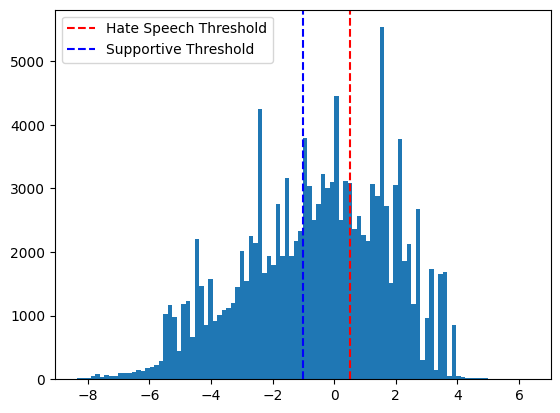

In [53]:
plot_hate_speech_score_histogram(df_raw, HATE_SPEECH_THRESHOLD_UNNORMALIZED, SUPPORTIVE_THRESHOLD_UNNORMALIZED)

### 2.2. Filtering & reformating

In [54]:
# Check for duplicate rows based on the 'comment_id' column
duplicate_texts = df_raw[df_raw.duplicated(subset='comment_id', keep=False)]
print(f"Number of duplicate texts: {duplicate_texts.shape[0]}")
duplicate_texts[['comment_id', 'text']].head()

Number of duplicate texts: 125479


,comment_id,text
0,47777,Yes indeed. She sort of reminds me of the elde...
1,39773,The trans women reading this tweet right now i...
2,47101,Question: These 4 broads who criticize America...
3,43625,It is about time for all illegals to go back t...
4,12538,For starters bend over the one in pink and kic...


In [55]:
# Group by 'comment_id' and count unique 'hate_speech_score' values per group
score_check = df_raw.groupby("comment_id")["hate_speech_score"].nunique()

# Find texts with more than one unique score
inconsistent = score_check[score_check > 1]

# Show how many inconsistencies there are
print(f"Number of 'comment_id' entries with inconsistent scores: {len(inconsistent)}")

# Optionally, view a few examples
if not inconsistent.empty:
    print(df_raw[df_raw["comment_id"].isin(inconsistent.index)].sort_values("comment_id").head(10))

Number of 'comment_id' entries with inconsistent scores: 0


In [56]:
# Step 1: Select relevant columns
df_relevant = df_raw[cols_to_keep].copy()

# Step 2: Convert booleans to integers for mean calculation
bool_cols = [col for col in df_relevant.columns if col.startswith('target_')]
df_relevant[bool_cols] = df_relevant[bool_cols].astype(int)

# Step 3: Group by 'comment_id' and 'text' to keep them in final output
filtered_df = df_relevant.groupby(['comment_id', 'text']).mean().reset_index()

In [57]:
min_score = filtered_df['hate_speech_score'].min()  # e.g., -8.34
max_score = filtered_df['hate_speech_score'].max()  # e.g., +6.3

# replace hate speech core column with normalized column - [0, 1]
filtered_df['hate_speech_score'] = (filtered_df['hate_speech_score'] - min_score) / (max_score - min_score)


In [58]:
# Normalize the thresholds given by the dataset authors
HATE_SPEECH_THRESHOLD_NORMALIZED = (0.5 - min_score) / (max_score - min_score)  
SUPPORTIVE_THRESHOLD_NORMALIZED = (-1 - min_score) / (max_score - min_score)

# Add binary columns for hate speech
filtered_df.insert(filtered_df.columns.get_loc('hate_speech_score') + 1, 'is_hate_speech', (filtered_df['hate_speech_score'] > HATE_SPEECH_THRESHOLD_NORMALIZED).astype(int))

# Print new normalized thresholds 
print(f"Threshold for hate speech: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} on the original scale")
print(f"Threshold for counter speech: {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {-1} on the original scale")
print(f"Between the two thresholds: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} and {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} and {-1} on the original scale which is the unambiguous region")


Threshold for hate speech: 0.604 -> Equivalent to 0.5 on the original scale
Threshold for counter speech: 0.501 -> Equivalent to -1 on the original scale
Between the two thresholds: 0.604 and 0.501 -> Equivalent to 0.5 and -1 on the original scale which is the unambiguous region


In [59]:
filtered_df.describe()

,comment_id,hate_speech_score,is_hate_speech,insult,humiliate,status,dehumanize,violence,genocide,target_race_asian,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
count,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,...,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000
mean,25064.175028,0.505197,0.261696,2.451707,2.170926,2.560852,1.700071,0.825427,0.448814,0.036070,...,0.001216,0.024744,0.002986,0.013872,0.006091,0.001186,0.001254,0.006339,0.002392,0.025676
std,14573.790336,0.141604,0.439563,1.185507,1.147433,0.699245,1.098025,1.000165,0.765847,0.161093,...,0.028330,0.137500,0.046627,0.105851,0.068472,0.029225,0.030446,0.068151,0.041602,0.146039
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12336.000000,0.410519,0.000000,1.666667,1.333333,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24986.000000,0.521858,0.000000,3.000000,2.333333,2.500000,1.666667,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37837.000000,0.608607,1.000000,3.333333,3.000000,3.000000,2.500000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50070.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   comment_id                             39565 non-null  int32  
 1   text                                   39565 non-null  object 
 2   hate_speech_score                      39565 non-null  float64
 3   is_hate_speech                         39565 non-null  int64  
 4   insult                                 39565 non-null  float64
 5   humiliate                              39565 non-null  float64
 6   status                                 39565 non-null  float64
 7   dehumanize                             39565 non-null  float64
 8   violence                               39565 non-null  float64
 9   genocide                               39565 non-null  float64
 10  target_race_asian                      39565 non-null  float64
 11  ta

### 2.3. Post-filtering EDA

In [ ]:
plot_hate_speech_score_histogram(filtered_df, HATE_SPEECH_THRESHOLD_NORMALIZED, SUPPORTIVE_THRESHOLD_NORMALIZED)

In [ ]:
plot_target_columns_distribution(filtered_df, target_cols_lvl1)
plot_target_columns_detailed(filtered_df, target_cols_lvl1)

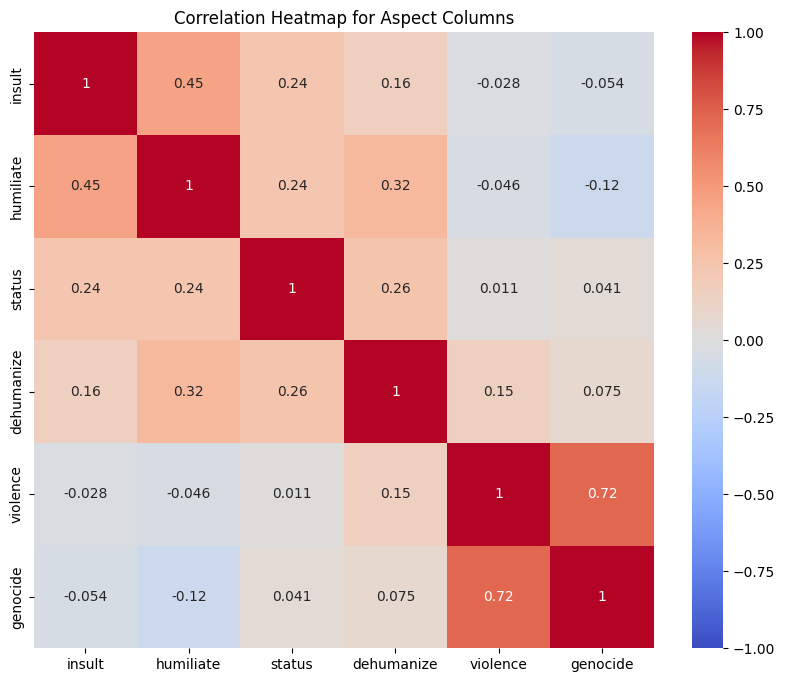

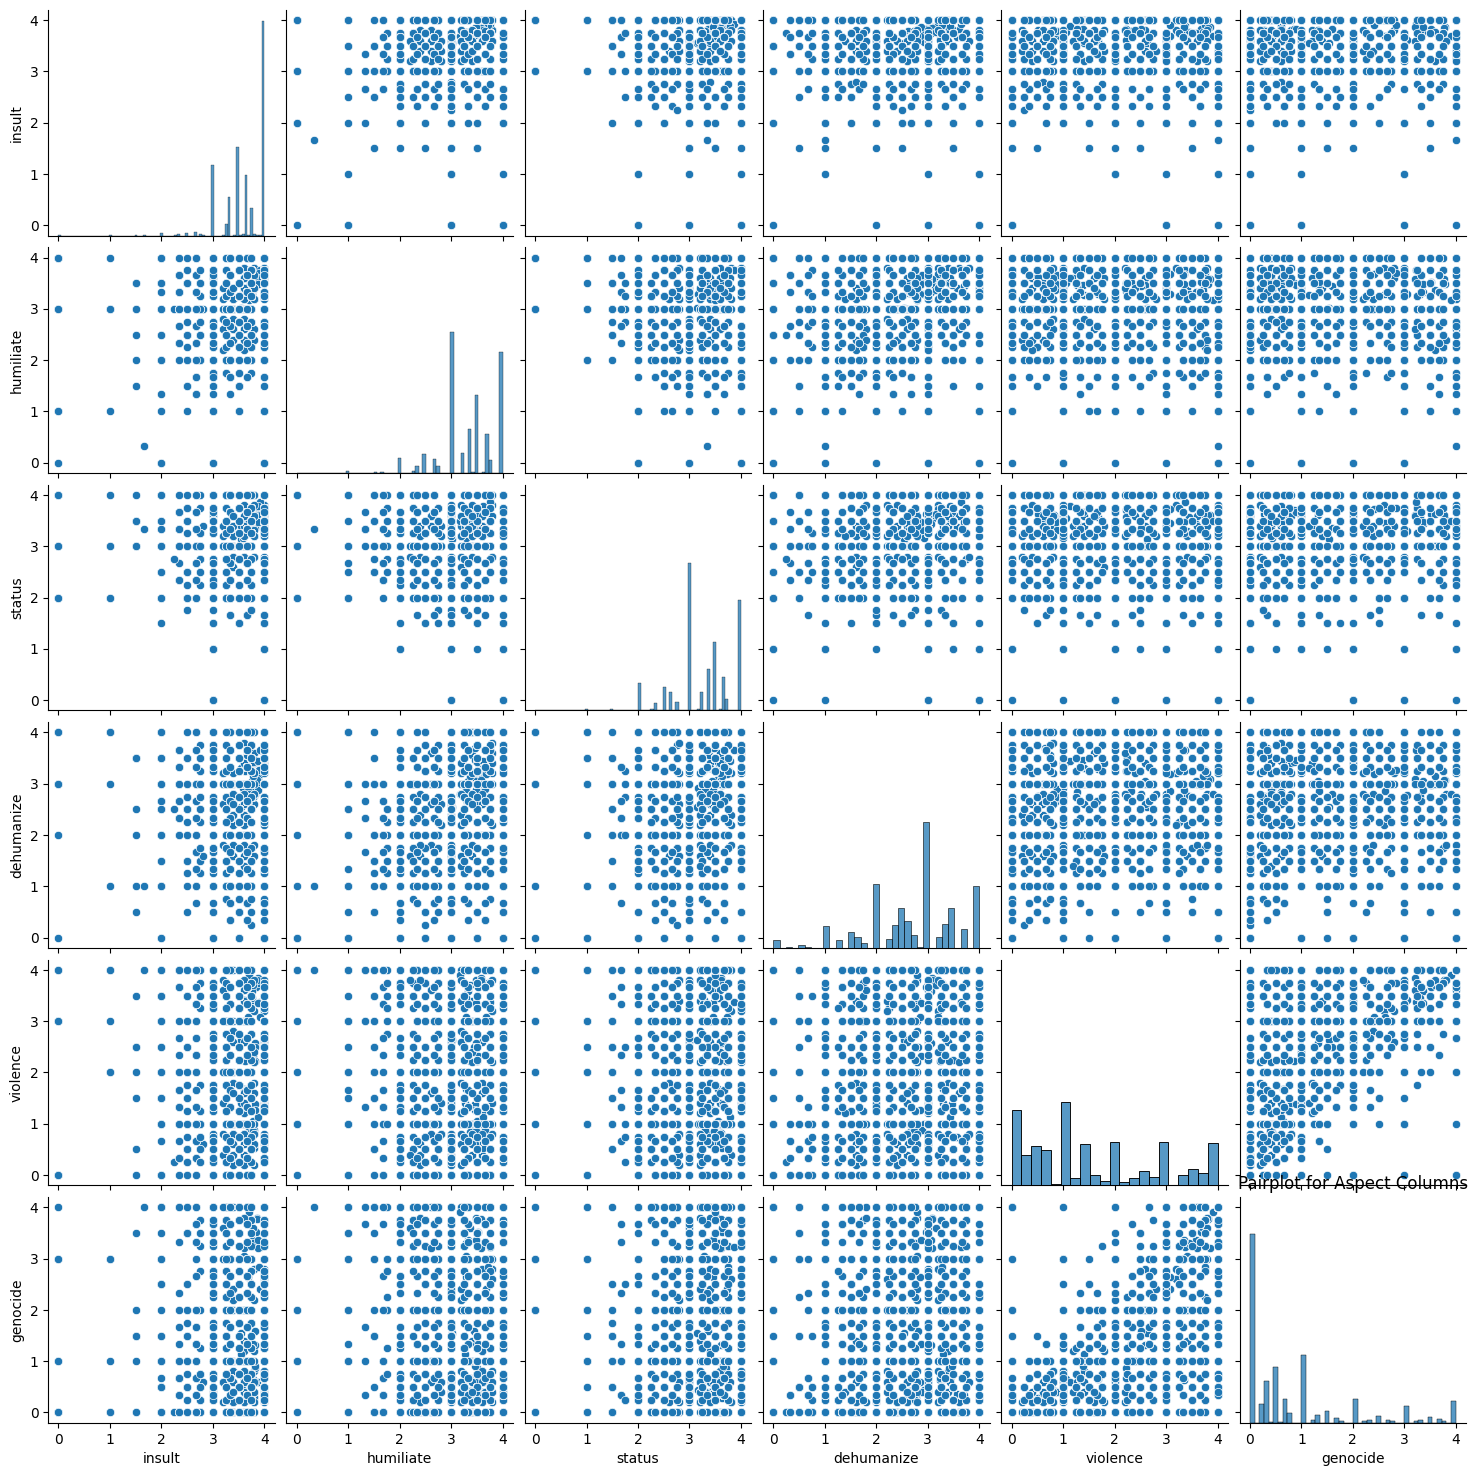

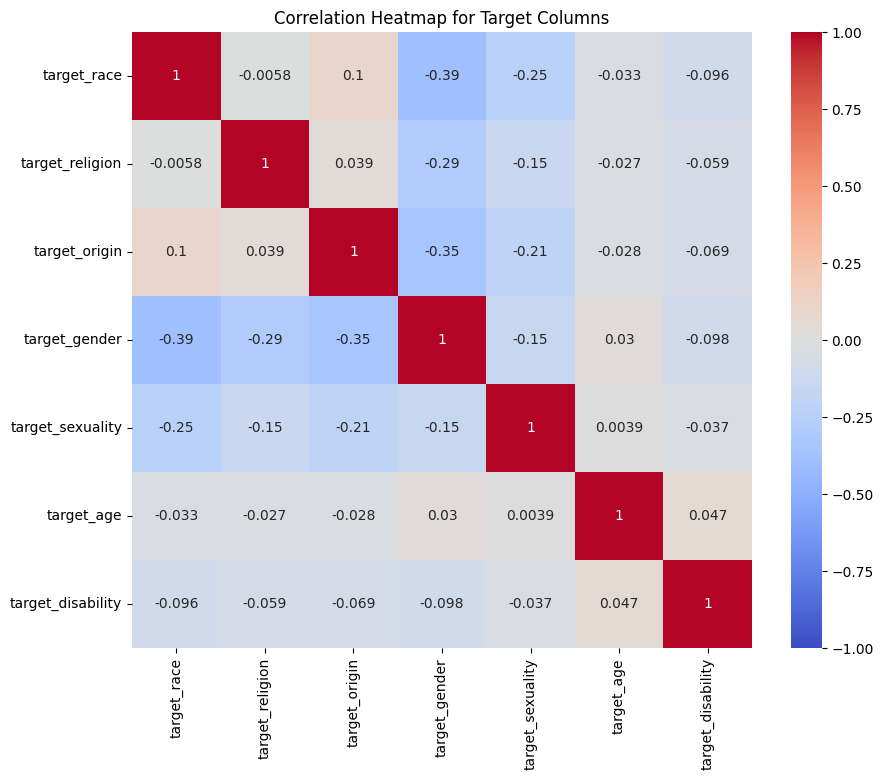

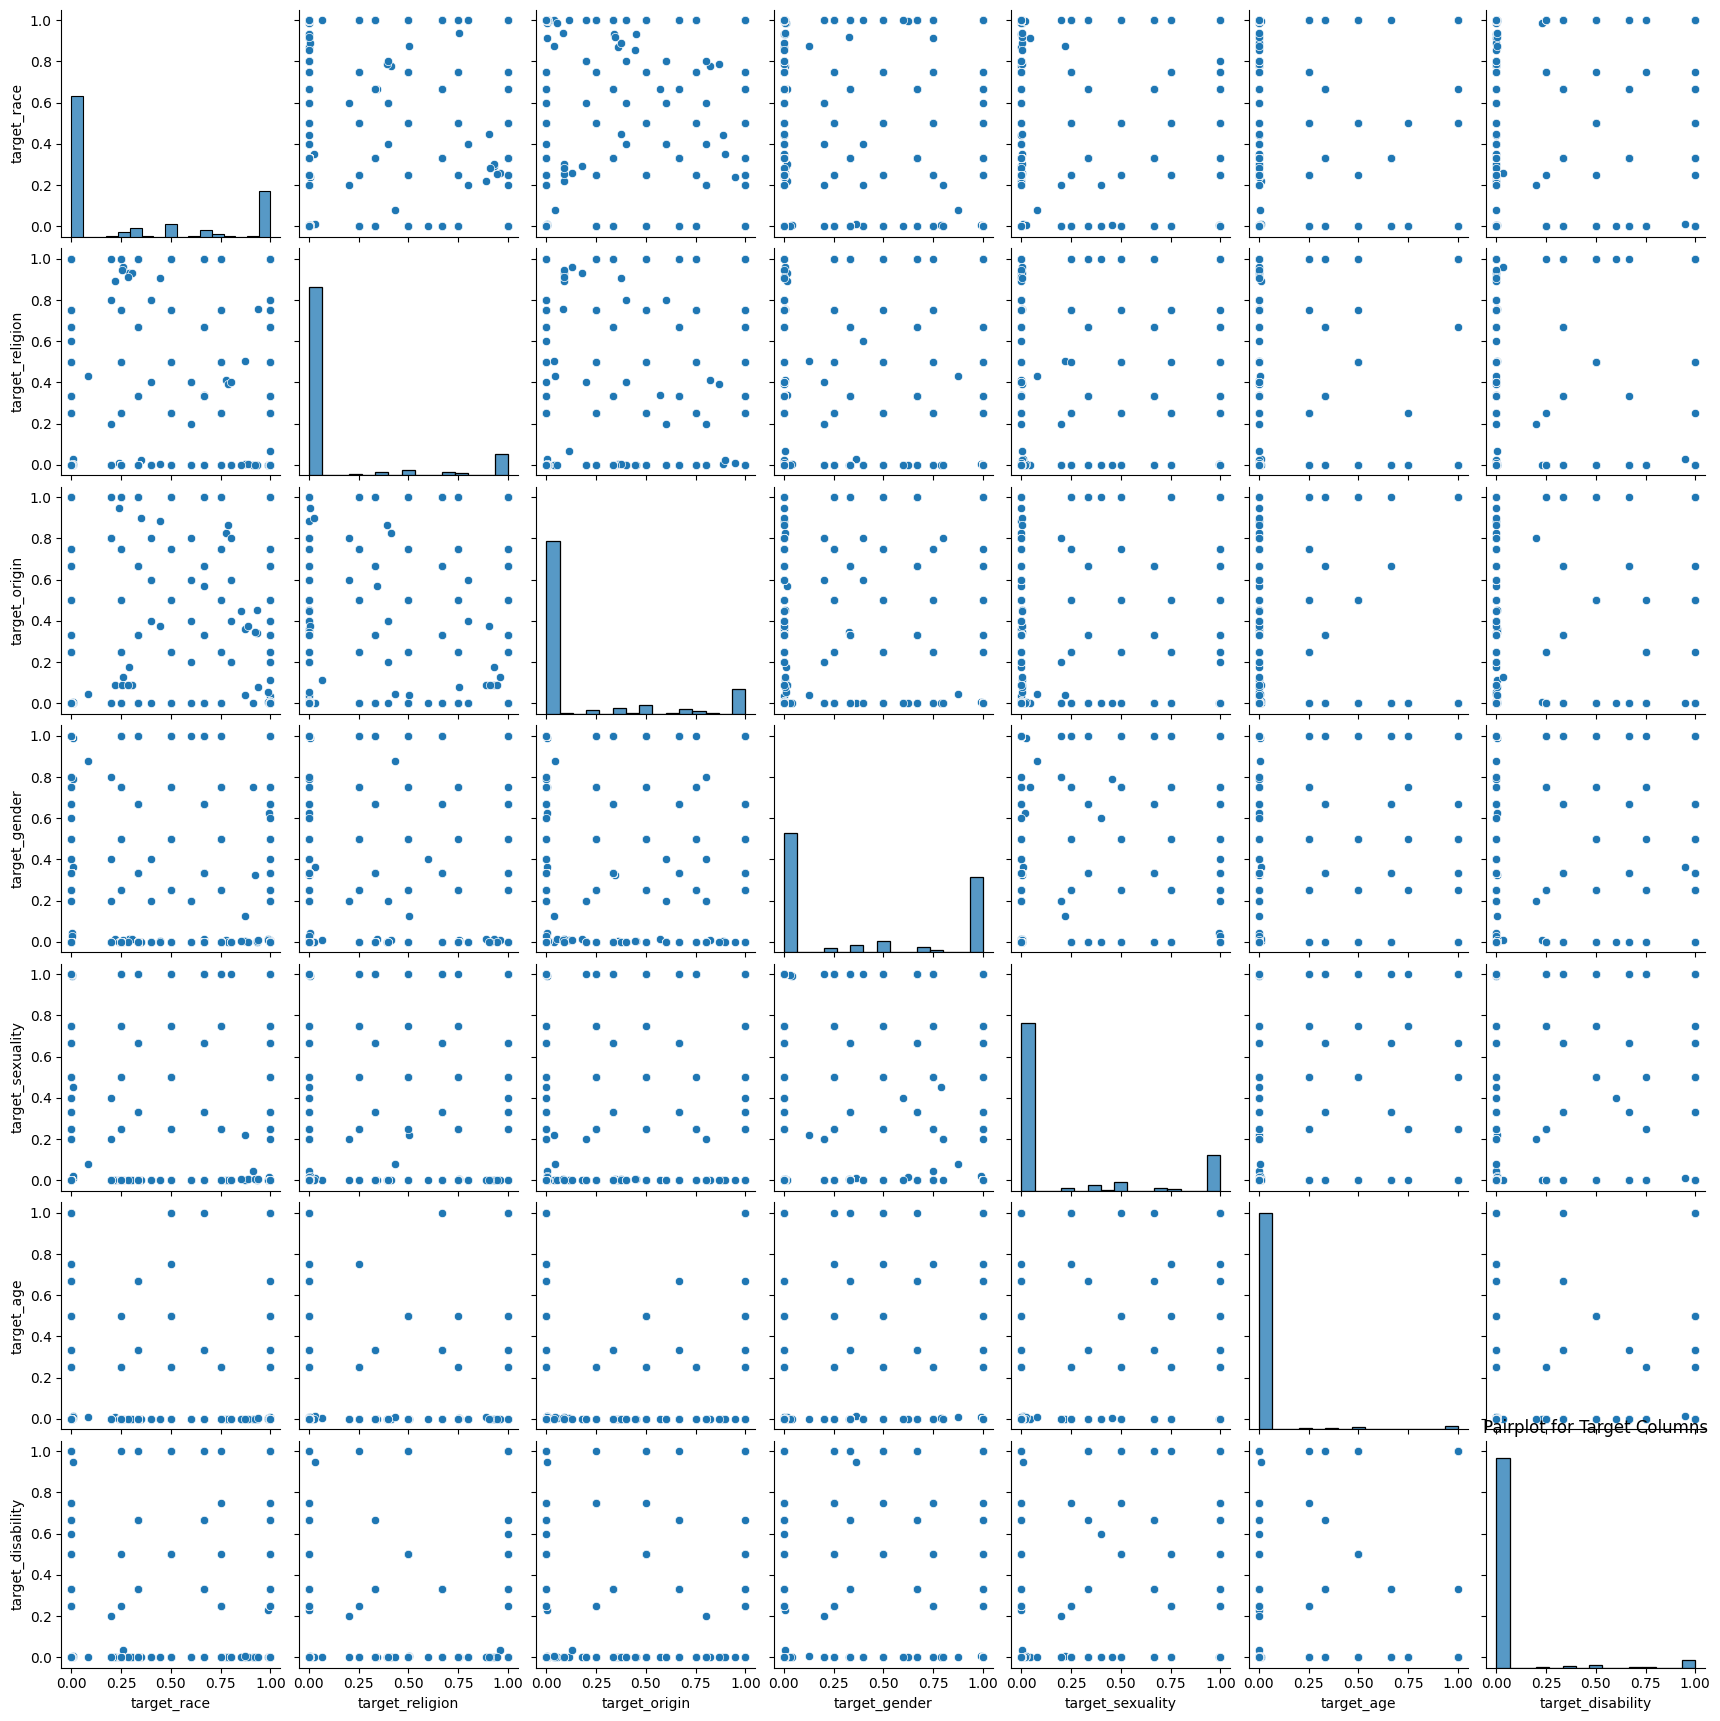

In [65]:
def inspect_for_cor(df, columns: list[str], plot_label: str, hate_speech_only: bool = True):

    # filter for hate speech only if specified
    if hate_speech_only:
        df = df[df['is_hate_speech'] == 1]
    
    # Make a correlation matrix
    corr_matrix = df[columns].corr()

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for {plot_label}')
    plt.show()

    # Make a pairplot of the columns
    sns.pairplot(df[columns])
    plt.title(f'Pairplot for {plot_label}')
    plt.show()

inspect_for_cor(filtered_df, aspect_cols, 'Aspect Columns')
inspect_for_cor(filtered_df, target_cols_lvl1, 'Target Columns')

# 3. Models

### 3.1. BoW

In [11]:
# Dataframe for Bag of Words (BoW) representation
bow_df = agg_df.copy()

# Releveant columns
cols_to_keep = ['text', 'is_hate_speech']

# Select relevant columns
bow_df = bow_df[cols_to_keep].copy()

In [ ]:
label_counts = bow_df['is_hate_speech'].value_counts()
label_percentage = bow_df['is_hate_speech'].value_counts(normalize=True) * 100

print("Label Counts:")
print(label_counts)
print("\nLabel Percentage Distribution:")
print(label_percentage)

## 3.1 Data preprocessing

## TODO: Maybe remove preprocessing from pipepine to just have it done once for "Part 2" of Assignment 3 approach

In [13]:
# Download necessary NLTK resources
for resource in ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger']:
    nltk.download(resource, quiet=True)

# Tokenizer
tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """
    Convert the part of speech tag to a format that WordNet lemmatizer can understand.
    starts with 'J' for adjectives, 'V' for verbs, 'N' for nouns, and 'R' for adverbs.
    Args:
        tag (str): The part of speech tag.
    Returns:
        str: The WordNet part of speech tag.
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def is_ascii(token):
    return all(ord(c) < 128 for c in token)

def remove_repeated_chars(token, threshold=3):
    return re.sub(r'(.)\1{' + str(threshold) + r',}', r'\1', token)

def preprocess(text):
    """
    Preprocess the text by tokenizing, removing punctuation, stop words,
    and lemmatizing the words.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    Example:
        >>> preprocess("This is an EXAMPLE sentence!!!.")
        'example sentence'
        
    """
    tokens = tknzr.tokenize(text) # Tokenize the text
    tokens = [word.lower() for word in tokens if word not in string.punctuation] # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    tokens = [remove_repeated_chars(word) for word in tokens] # Remove repeated characters, ex: "loooove" -> "love"
    tokens = [word for word in tokens if len(word) >= 2 and is_ascii(word)]  # Filter by length and ASCII
    pos_tags = pos_tag(tokens) # Get part of speech tags
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags] # Lemmatize the words using the part of speech tags
    return " ".join(lemmatized)

In [14]:

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.progress_apply(preprocess)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

pipeline_bow = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

## 3.2 Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

X = bow_df['text']
y = bow_df['is_hate_speech']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 3.3 Fit model to training set - BoW + LogReg

In [ ]:
# Fit the pipeline to the training data
pipeline_bow.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred_bow = pipeline_bow.predict(X_test)

# Generate the classification report
report_bow = classification_report(y_test, y_pred_bow, output_dict=True)

In [19]:
results = []
results.append({
    'model': 'BoW + LogisticRegression',
    'precision_hate': report_bow['1']['precision'],
    'recall_hate': report_bow['1']['recall'],
    'f1_hate': report_bow['1']['f1-score'],
    'accuracy': report_bow['accuracy']
})

## 3.4 Fit model to training set - TFIDF + LogRes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline_tfidf = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

pipeline_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipeline_tfidf.predict(X_test)

report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)

In [21]:
results.append({
    'model': 'TF-IDF + LogisticRegression',
    'precision_hate': report_tfidf['1']['precision'],
    'recall_hate': report_tfidf['1']['recall'],
    'f1_hate': report_tfidf['1']['f1-score'],
    'accuracy': report_tfidf['accuracy']
})

## 3.4.1 Hyperparameter tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

pipeline_tuned = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),  # or CountVectorizer()
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

param_grid = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_features': [5000, 10000],
    'vectorizer__max_df': [0.75, 0.9],
    'classifier__C': [0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # Needed for 'l1' penalty
}

grid_search = GridSearchCV(
    pipeline_tuned,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1',  # use 'f1' to focus on hate speech detection
    verbose=2, # print progress
    n_jobs=1  # use all CPU cores
)

grid_search.fit(X_train, y_train)

In [ ]:
print("Best params:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

# Use best model to predict test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)


print(classification_report(y_test, y_pred_tuned))

In [ ]:
results_df = pd.DataFrame(results)

results_df